In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from astroML.datasets import fetch_sdss_galaxy_colors

Use the `astroML` library to easily access the SDSS catalogue gathering colors and redshift for both galaxies and QSO

In [3]:
data = fetch_sdss_galaxy_colors()

In [4]:
data.shape

(50000,)

Put the data in a pandas dataframe so that I can manipulate them more easily

In [5]:
import pandas as pd

In [36]:
df = pd.DataFrame(data)

In [37]:
df.head(10)

,u,g,r,i,z,specClass,redshift,redshift_err
0,19.49566,18.02662,17.27279,16.80963,16.50546,GALAXY,0.075841,0.000013
1,19.13045,17.33345,16.46490,16.04447,15.74512,GALAXY,0.073897,0.000021
2,19.29607,17.70598,17.01379,16.56150,16.27961,GALAXY,0.065612,0.000007
3,19.55098,18.10776,17.26874,16.82792,16.51227,GALAXY,0.000000,0.000000
4,18.38099,16.62612,15.69422,15.20133,14.81006,GALAXY,0.089174,0.000025
5,18.86286,16.69946,15.68978,15.22769,14.87766,GALAXY,0.093321,0.000024
6,19.23903,18.04760,17.24049,16.78965,16.50770,GALAXY,0.178023,0.000018
7,19.44537,17.65007,16.73675,16.24927,15.87953,GALAXY,0.059962,0.000019
8,18.69437,18.42682,18.31702,18.12096,18.14960,QSO,1.575583,0.000245
9,18.28705,16.55338,15.69008,15.23252,14.92900,GALAXY,0.084557,0.000021


Create new features: the standard colors u-g, g-r, r-i, i-z, taken from the observed u,g,r,i,z magnitudes

In [38]:
df['u-g'] = df['u'] - df['g']
df['g-r'] = df['g'] - df['r']
df['r-i'] = df['r'] - df['i']
df['i-z'] = df['i'] - df['z']

# Data exploration
Plot the sdss data and the classes, cutting around the proper limit in colors 

(-0.5, 1.5)

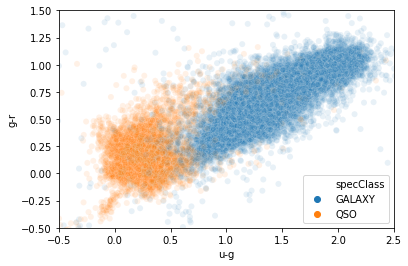

In [39]:
sns.scatterplot(df['u-g'], df['g-r'], hue=df['specClass'], alpha=0.1)
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)

Cut the dataset to have the range of colors between -0.5 and 2.5 for u-g, and -0.5 1.5 for g-r which are physical values

In [40]:
df.drop(df[np.logical_not(np.logical_and(df['u-g']<2.5, df['u-g']>-0.5))].index, inplace=True)
df.drop(df[np.logical_not(np.logical_and(df['g-r']<1.5, df['g-r']>-0.5))].index, inplace=True)

In [41]:
df.head()

,u,g,r,i,z,specClass,redshift,redshift_err,u-g,g-r,r-i,i-z
0,19.49566,18.02662,17.27279,16.80963,16.50546,GALAXY,0.075841,0.000013,1.46904,0.75383,0.46316,0.30417
1,19.13045,17.33345,16.46490,16.04447,15.74512,GALAXY,0.073897,0.000021,1.79700,0.86855,0.42043,0.29935
2,19.29607,17.70598,17.01379,16.56150,16.27961,GALAXY,0.065612,0.000007,1.59009,0.69219,0.45229,0.28189
3,19.55098,18.10776,17.26874,16.82792,16.51227,GALAXY,0.000000,0.000000,1.44322,0.83902,0.44082,0.31565
4,18.38099,16.62612,15.69422,15.20133,14.81006,GALAXY,0.089174,0.000025,1.75487,0.93190,0.49289,0.39127


Plot the selected data in the color-color diagram as a function of redshift

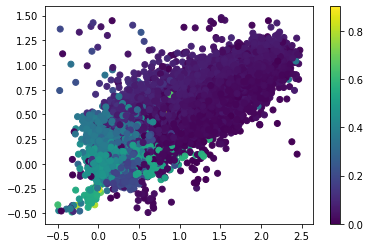

In [43]:
plt.scatter(df['u-g'], df['g-r'], c=np.log10(1+df['redshift']))
plt.colorbar()

Fit a machine learning model that, considering the features available (u, g, r, i, z filter photometry), is able to predict the redshift of the sources. The RMS error will be the adopted metric for the evaluation of the model.

In [77]:
# now let's use sklearn to split the dataset and create test and train 
from sklearn.model_selection import train_test_split
X, y = df[['u-g', 'g-r', 'r-i', 'i-z']].values[:], df[['redshift']].values[:],
y=np.ravel(y)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

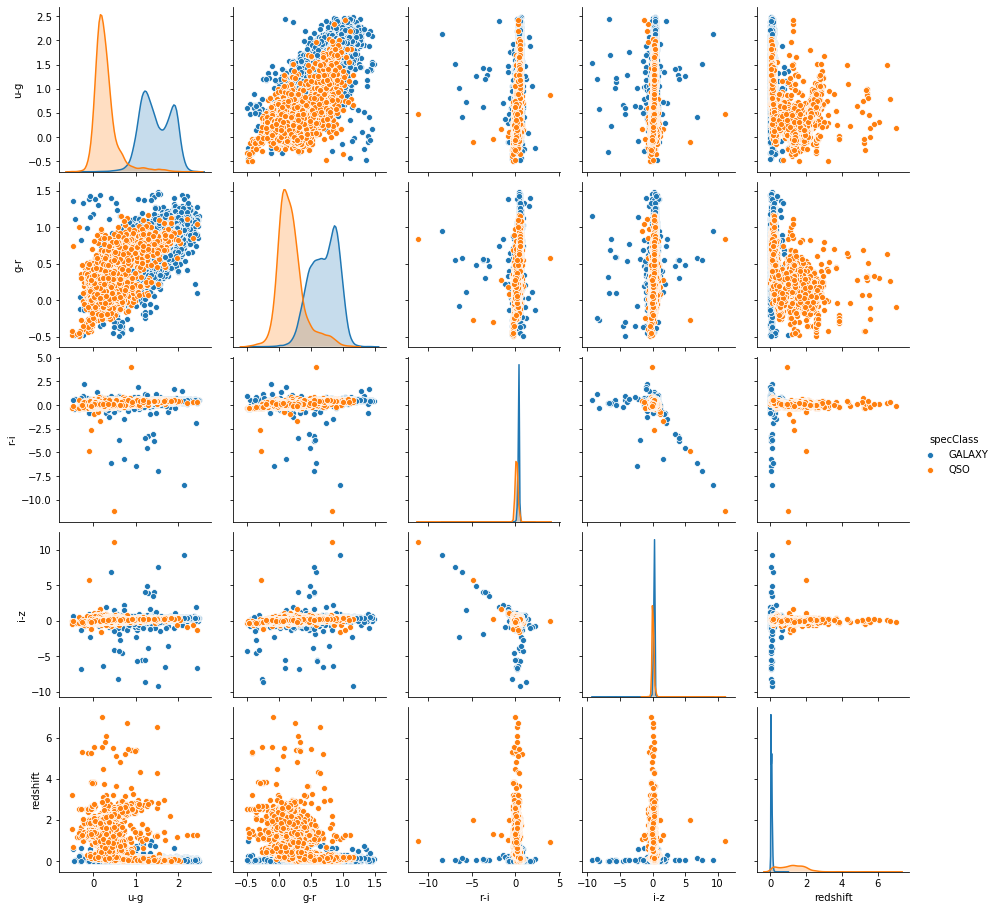

In [57]:
import seaborn as sns

sns.pairplot(df, x_vars=['u-g', 'g-r', 'r-i', 'i-z','redshift'], 
                 y_vars=['u-g', 'g-r', 'r-i', 'i-z', 'redshift'],
                 hue="specClass")

Let's forget for the moment that there is a clear difference between QSO and Galaxy in redshift, and 
let see whether a KNeighbors algorithm
is able to retrieve the z_ from colors



In [79]:
from sklearn.neighbors import KNeighborsRegressor
# train the model assuming (pretty blidly) n_neighbors=10
model = KNeighborsRegressor(n_neighbors=10)
model_knn= model.fit(X_train, y_train)

In [80]:
# test the model
y_pred = model_knn.predict(X_test)

In [81]:
# print the accuracy
model_knn.score(X_test, y_test)

0.8116072270978033

<ErrorbarContainer object of 3 artists>

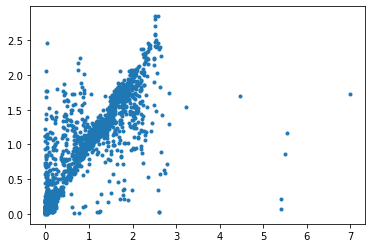

In [83]:
plt.errorbar(y_test, y_pred, ls='', marker='.')

In [62]:
rms = np.sqrt(np.mean((y_test - y_pred)** 2))
print("RMS error = %.2g" % rms)

RMS error = 0.21


Now let's try to improve the performance by trying different values for k neighbors
We create a function called `plot_complexity_curve` which takes possible numbers for neighbors, the model itself, and the data as arguments. Then, for each k, it initializes, fits, and scores the given model both on training and test sets.

Scoring the model both on training and test sets will give you a good idea of what values lead to overfitting and underfitting:

In [63]:
def plot_complexity_curve(k_list, knn_model, x_tr, x_te, y_tr, y_te):
    
    train_scores = []
    test_scores = []
    
    # For each k
    for k in k_list:
        # Initialize, fit, predict
        knn = knn_model(k)
        
        knn.fit(x_tr, y_tr)
        
        train_scores.append(knn.score(x_tr, y_tr))
        test_scores.append(knn.score(x_te, y_te))

    # Plot
    fig, ax = plt.subplots()
    
    ax.plot(k_list, train_scores, label='Training Accuracy', color='red')
    ax.plot(k_list, test_scores, label='Testing Accuracy', color='black')

    ax.set(title='k-NN with Different Values for $k$',
           xlabel='Number of Neighbors',
           ylabel='Accuracy')
    
    ax.legend()

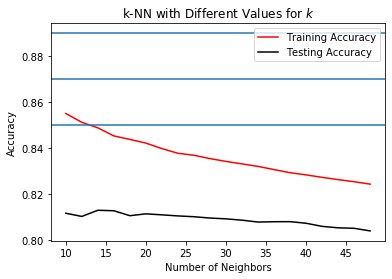

In [65]:
# Create possible values for k
neighbors = np.arange(10, 50, 2)

plot_complexity_curve(neighbors, KNeighborsRegressor, 
                    X_train, X_test, y_train, y_test)
plt.axhline(y=0.85)
plt.axhline(y=0.87)
plt.axhline(y=0.89)

For the KNeighborsRegressor it seems that any number of neighbors approx 15 is a good hyperparameter.

Obviously there is further room for improving:
we can for instance scale the features so that they range between 0 and 1.
This can be done using a MinMax scaling or the StandardScaler

In [66]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [69]:
scaler = MinMaxScaler()
Xscaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size=0.2, random_state=42)

Now let's to the same as before, i.e. searching for the best k value according to the accuracy

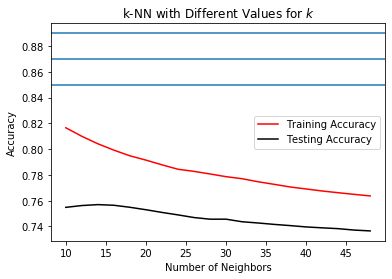

In [70]:
plot_complexity_curve(neighbors, KNeighborsRegressor, 
                    X_train, X_test, y_train, y_test)
plt.axhline(y=0.85)
plt.axhline(y=0.87)
plt.axhline(y=0.89)

In [74]:
#In this case the minmaxscaler or the standardscaler do not help at all
# train the model assuming the k neighbors suggested by the former analysis
model = KNeighborsRegressor(n_neighbors=12)
model_knn= model.fit(X_train, y_train)

In [75]:
# test the model
y_pred = model_knn.predict(X_test)

In [76]:
# print the accuracy
model_knn.score(X_test, y_test)

0.7562611627254416